In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time
import itertools

In [27]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [28]:
def generateData(data, perm):
    n = data.shape[0]
    blockSize = n // len(perm)
    dataSet = np.zeros(data[0].shape)
    for i in perm:
        block = data[i*blockSize:(i+1)*blockSize]
#         print(block, end='\n\n')
        dataSet = np.vstack((dataSet, block))
    dataSet = dataSet[1:]
    return dataSet

In [29]:
# dataframe = read_csv('sp500.csv')
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)
print(data.shape)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039
(1259, 2)


In [30]:
# dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [31]:
split = 0.75
trainSize = int(len(data)*split)
testSize = len(data)-trainSize
print(trainSize)
print(testSize)

944
315


In [32]:
numInterval = 3
blockSize = trainSize//numInterval
print(blockSize)


314


In [33]:
    train = data[0:trainSize,:]
    test = data[trainSize:len(data),:]
    print(train[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


Epoch 1/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0014
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 3.3953e-04
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 2.8799e-04
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 2.6247e-04
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 2.1917e-04
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 1.9334e-04
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 1.6246e-04
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 1.4825e-04
Epoch 9/20
938/938 [==============================] - 5s 5ms/step - loss: 1.4138e-04
Epoch 10/20
938/938 [==============================] - 6s 6ms/step - loss: 1.4318e-04
Epoch 11/20
938/938 [==============================] - 4s 4ms/step - loss: 1.3699e-04
Epoch 12/20
938/938 [==============================] - 3s 3ms/step 

Epoch 15/20
938/938 [==============================] - 3s 3ms/step - loss: 4.6137e-04
Epoch 16/20
938/938 [==============================] - 3s 3ms/step - loss: 4.8812e-04
Epoch 17/20
938/938 [==============================] - 3s 3ms/step - loss: 5.1785e-04
Epoch 18/20
938/938 [==============================] - 3s 3ms/step - loss: 5.1371e-04
Epoch 19/20
938/938 [==============================] - 3s 3ms/step - loss: 4.8455e-04
Epoch 20/20
938/938 [==============================] - 3s 3ms/step - loss: 4.7766e-04
Train Score: 15.66 RMSE
Test Score: 10.49 RMSE
Epoch 1/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0022
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 8.3438e-04
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 7.4059e-04
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 6.7244e-04
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 5.2710e-04
Epoch 6/20
938/9

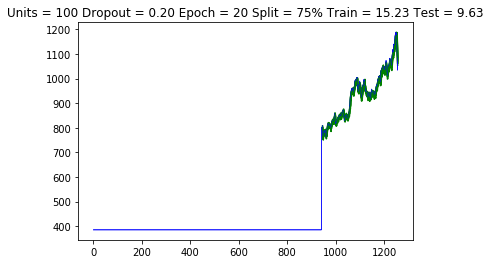

In [37]:
# print(train, end="\n\n")
permutations = itertools.permutations(range(numInterval))
for perm in permutations:
#     print(perm)
    trainSet = generateData(train, perm)
    trainSet = np.reshape(trainSet, trainSet.shape)
#     print(trainSet)
    shuffleData = np.vstack((trainSet, test))

    lookBack = 3
    trainX, trainY = create_dataset(trainSet, lookBack)
    testX, testY = create_dataset(test, lookBack)

    # trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
    # testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

    units = 100
    drop = 0.2
    epoch = 20

    model = Sequential()
    model.add(LSTM(units, input_shape=(lookBack, 2)))
    # model.add(Dropout(drop))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='nadam')
#     model.summary()
#     tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#     model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])
    model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1)

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

    trainPredictPlot = np.empty_like(shuffleData)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict

    testPredictPlot = np.empty_like(shuffleData)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lookBack*2)+2:len(data)-1, :] = testPredict
#     testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(data)-1, :] = testPredict

    col = 0
    testPlot = np.empty_like(trainSet)
    testPlot[:, :] = 0
    testPlot = np.vstack((testPlot, test))
#     plt.plot(scaler.inverse_transform(shuffleData)[:,col])
#     plt.plot(trainPredictPlot[:,col], color = 'orange')
    plt.plot(testPredictPlot[:,col], color = 'green')
    plt.plot(scaler.inverse_transform(testPlot)[:,col], color = 'blue', linewidth = 0.3)
    plt.title('Units = %d Dropout = %.2f Epoch = %d Split = %d%% Train = %.2f Test = %.2f' % 
            (units, drop, epoch, split*100, trainScore, testScore))
plt.show()